# Analysis of BioImages (in Progress)

This is becoming a collection of Python-based example codes focussing on image analysis of biological matter. Apologies for the code often being a little sloppy and "easy-going". Due to a limited time frame, priorities were set to "progress & visualization" instead of "finding the most efficient solution" :) <br>
Whenever a function or method is developed to fulfill the goals, it is outsources into the subfolder "ModulesOwn", take a look and have fun. Check out my website (www.bio-century.net) for more projects, literature recommendations, links to data bases and further inspirations.

# Table of Contents
0. [Reference Table](#ReferenceTable)
1. [Nuclei Detection on Fluorescence Images](#NucleiDetectionOnFluorescenceImages)
   1. [First Analysis on an Example Micrograph](#FirstAnalysisOnAnExampleMicrograph)
   2. [Statistical Analysis of Automated Nuclei Cell Count](#StatisticalAnalysisOfAutomatedNucleiCellCount)
   3. [Ellipse Fit on Nuclei](#EllipseFitOnNuclei)
2. [Appendix](#Appendix)
     1.   [.html-Export of Code](#htmlExportOfCode)

# 1. <a name="NucleiDetectionOnFluorescenceImages">Nuclei Detection on Fluorescence Images</a>

## 1.1 <a name="FirstAnalysisOnAnExampleMicrograph">First Analysis on an Example Micrograph</a>

Goal:
Count nuclei of a fluorescence micrograph in an automated way

Steps 1: Import micrograph and compute a binary mask.

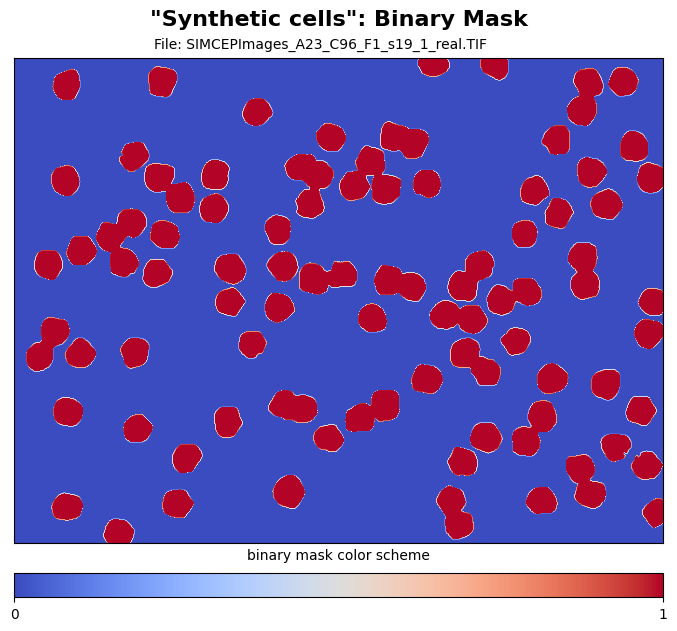

In [1]:
# sources
# https://bbbc.broadinstitute.org/BBBC005
# https://bbbc.broadinstitute.org/search/synthetic%20cells?
# https://www.geeksforgeeks.org/distance-transformation-in-image-python-opencv/
# https://www.geeksforgeeks.org/how-to-adjust-the-position-of-a-matplotlib-colorbar/
# https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_watershed/py_watershed.html
# https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html
# https://stackoverflow.com/questions/70361424/extract-white-regions-from-binary-images
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.binary_fill_holes.html
# https://www.tutorialspoint.com/how-to-compute-the-area-and-perimeter-of-an-image-contour-using-opencv-python
# https://www.youtube.com/watch?v=WQpXS9gBEu8


# data source
# Synthetic cells, Accession number BBBC005 · Version 1
# A. Lehmussola, P. Ruusuvuori, J. Selinummi, H. Huttunen and O. Yli-Harja,
# "Computational Framework for Simulating Fluorescence Microscope Images With Cell Populations,"
# in IEEE Transactions on Medical Imaging, vol. 26, no. 7, pp. 1010-1016, July 2007, doi: 10.1109/TMI.2007.896925.
# 
# A. Lehmussola, P. Ruusuvuori, J. Selinummi, T. Rajala and O. Yli-Harja,
# "Synthetic Images of High-Throughput Microscopy for Validation of Image Analysis Methods,"
# in Proceedings of the IEEE, vol. 96, no. 8, pp. 1348-1360, Aug. 2008, doi: 10.1109/JPROC.2008.925490.


# import modules
import cv2
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy import ndimage

# define filenames and parameters
# fileName           = "SIMCEPImages_A23_C96_F1_s19_w1.TIF"                     # mask
fileName          = "SIMCEPImages_A23_C96_F1_s19_1_real.TIF"                    # "real" image
cellCountTruth     = int(fileName[fileName.find('_C')+2:fileName.find('_F')])   # extract real cell number from filename
myThresholdValue   = 70                                                         # treshold value for binary mask

myImage            = cv2.imread('./ModulesExternal/Data/' + fileName)           # read image
myImageGray        = cv2.cvtColor(myImage, cv2.COLOR_BGR2GRAY)
# ret, thresh        = cv2.threshold(gray, 0, 1, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# fill holes

# define binary mask on computed on thresholded image
myImageThresholded                                = np.zeros(myImageGray.shape)
myImageThresholded[myImageGray > myThresholdValue] = 1
myImageThresholded                                = ndimage.binary_fill_holes(myImageThresholded).astype(int)

# plot figure
fig, ax            = plt.subplots(figsize = (15, 7))
im                 = ax.imshow(myImageThresholded, cmap = cm.coolwarm)
divider            = make_axes_locatable(ax)
cax                = divider.new_vertical(size = "5%", pad = 0.3, pack_start = True)
fig.add_axes(cax)
cbar               = fig.colorbar(im, cax = cax, ticks = [-1, 0, 1], orientation = 'horizontal')
TitleString = "\"Synthetic cells\": Binary Mask\n"
plt.title(TitleString, fontweight="bold", fontsize = 16, y = 22.3)
plt.suptitle("File: " + fileName, fontsize = 10, y = 0.91)
ax.set_xlabel("binary mask color scheme")
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Step 2: Identify single objects and draw contours

---------------------------
     Number of Cells
---------------------------
Detected: 		 74
True Value: 		 96
---------------------------
Merged Cells Delta: 	-22


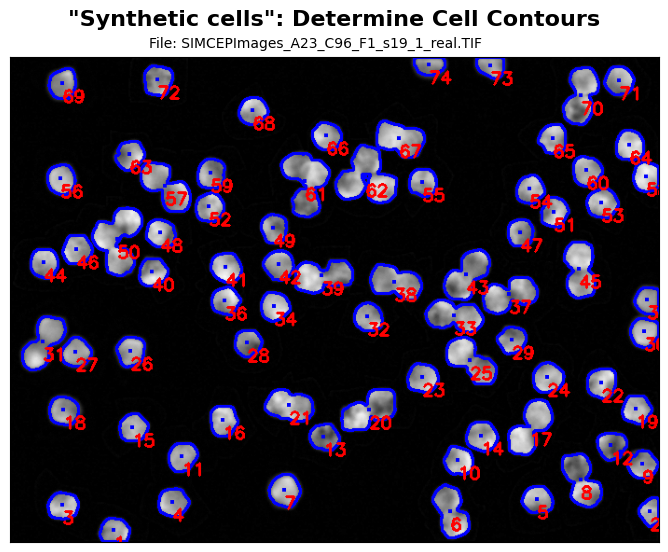

In [2]:
# sources
# https://www.kaggle.com/code/voglinio/separating-nuclei-masks-using-convexity-defects
# https://stackoverflow.com/questions/32401806/get-mask-from-contour-with-opencv
# https://stackoverflow.com/questions/50591442/convert-3-dim-image-array-to-2-dim
# https://www.tutorialspoint.com/how-to-compute-the-area-and-perimeter-of-an-image-contour-using-opencv-python

# source of main algorithm
# https://www.kaggle.com/code/voglinio/separating-nuclei-masks-using-convexity-defects
# User: Costas Voglis

# https://de.mathworks.com/matlabcentral/answers/43435-i-couldn-t-understand-convex-area
# prop.convex_area / prop.filled_area
# convex_area (convex hull): the smallest region that satisfy two conditions: (1) it is convex (2) it contains
# the original region.
# => The ratio increases the less convex the area is (multiple nuclei)


# import modules
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import regionprops
import ModulesOwn.A_Groundwork as Groundwork
from statistics import mean

# tresholds for
# 1Cell:             single cell
# 2CellCluster:      two cells
# gt2CellCluster:    greater than two cells
dictThresholdValues                 = {}
dictThresholdValues["1Cell"]        = 0
dictThresholdValues["2CellCluster"] = 1.05
dictThresholdValues["gt2CellCluster"] = 1.2

# compute mean area for a single nucleus
meanFilledAreaTmp = Groundwork.meanFilledArea(myImage, myImageThresholded, dictThresholdValues)

# execute main algorith to identify cells and cell cluster
cellCount, contours, myImageContours, myMaskContoursAll = Groundwork.identifyCellContoursAndAreaOverlays(myImage, 
                                                                                                         myImageThresholded, 
                                                                                                         dictThresholdValues,
                                                                                                         meanFilledAreaTmp)

# print table to compare cellcounts
print("-" * 27, end = '\n')
print("     Number of Cells")
print("-" * 27, end = '\n')
print("Detected: \t\t " + str(len(contours)))
print("True Value: \t\t " + str(cellCountTruth))
print("-" * 27, end = '\n')
print("Merged Cells Delta: \t" + str(len(contours) - cellCountTruth))

# plot figure
fig, ax = plt.subplots(figsize = (15, 7))
im      = ax.imshow(myImageContours, cmap = cm.coolwarm)
divider = make_axes_locatable(ax)
cax     = divider.new_vertical(size = "5%",
                           pad = 0.3,
                           pack_start = True)
TitleString = "\"Synthetic cells\": Determine Cell Contours\n"
plt.title(TitleString, fontweight = "bold", fontsize = 16)
plt.suptitle("File: " + fileName, fontsize = 10, y = 0.91)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Step 3: Identify multi-nuclei regions

---------------------------
     Number of Cells
---------------------------
Detected previously: 	 74
Detected now: 		 96
True Value: 		 96
---------------------------
Merged cells delta: 	 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


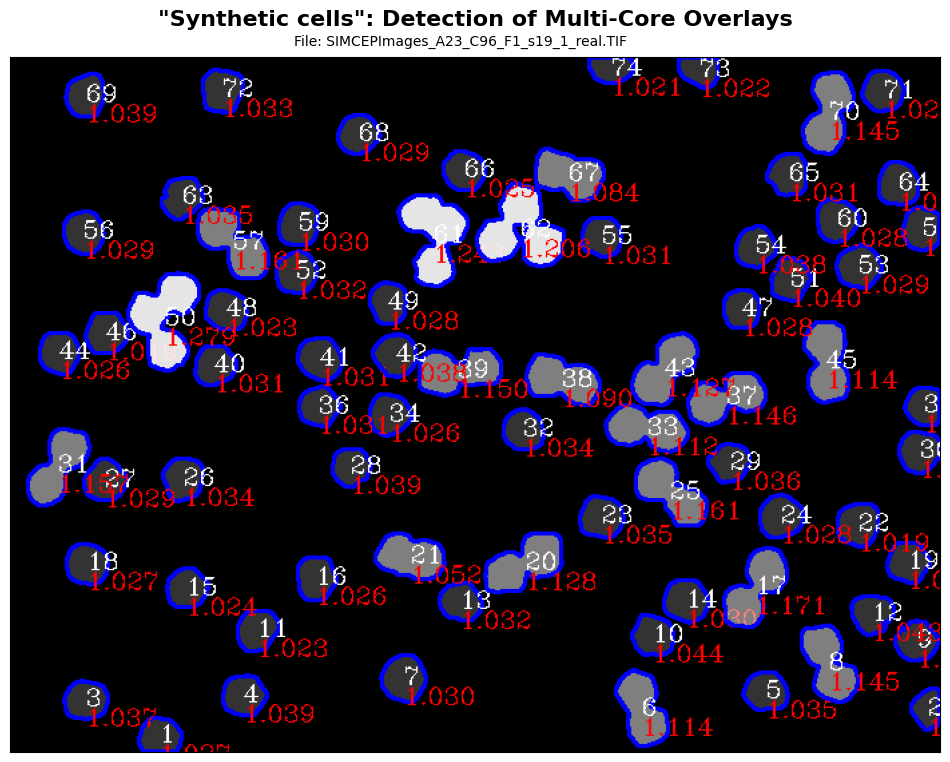

In [3]:
# sources
# https://www.kaggle.com/code/voglinio/separating-nuclei-masks-using-convexity-defects
# https://stackoverflow.com/questions/32401806/get-mask-from-contour-with-opencv
# https://stackoverflow.com/questions/50591442/convert-3-dim-image-array-to-2-dim
# https://www.tutorialspoint.com/how-to-compute-the-area-and-perimeter-of-an-image-contour-using-opencv-python

# print table to compare cellcounts
print("-" * 27, end = '\n')
print("     Number of Cells")
print("-" * 27, end = '\n')
print("Detected previously: \t " + str(len(contours)))
print("Detected now: \t\t " + str(cellCount))
print("True Value: \t\t " + str(cellCountTruth))
print("-" * 27, end = '\n')
print("Merged cells delta: \t " + str(cellCount - cellCountTruth))

# plot figure
fig, ax = plt.subplots(figsize = (15, 7))
fig.set_figwidth(12)
fig.set_figheight(12)
ax.imshow(myMaskContoursAll)
TitleString = "\"Synthetic cells\": Detection of Multi-Core Overlays\n"
plt.title(TitleString, fontweight="bold", fontsize = 16)
plt.suptitle("File: " + fileName, fontsize = 10, y = 0.803)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Step 4 (add-on): Compute distance transform

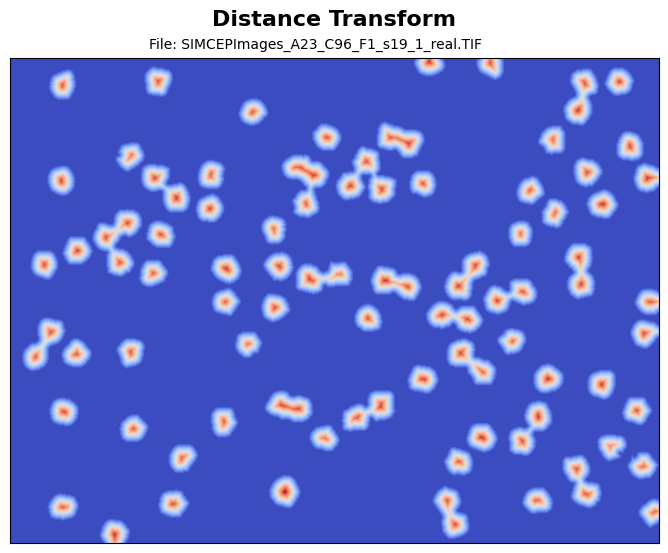

In [4]:
# source
# https://www.geeksforgeeks.org/distance-transformation-in-image-python-opencv/

# import modules
import cv2
import numpy as np

distTransform = cv2.distanceTransform(myImageThresholded.astype(np.uint8), cv2.DIST_L2, 3)
fig, ax = plt.subplots(figsize = (15, 7))
im      = ax.imshow(distTransform, cmap = cm.coolwarm)
divider = make_axes_locatable(ax)
cax     = divider.new_vertical(size = "5%",
                           pad = 0.3,
                           pack_start = True)

# plot figure
plt.title("Distance Transform", fontweight="bold", fontsize = 16, y = 1.05)
plt.suptitle("File: " + fileName, fontsize = 10, y = 0.91)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Step 5 (add-on): Compute watershed results and overlay

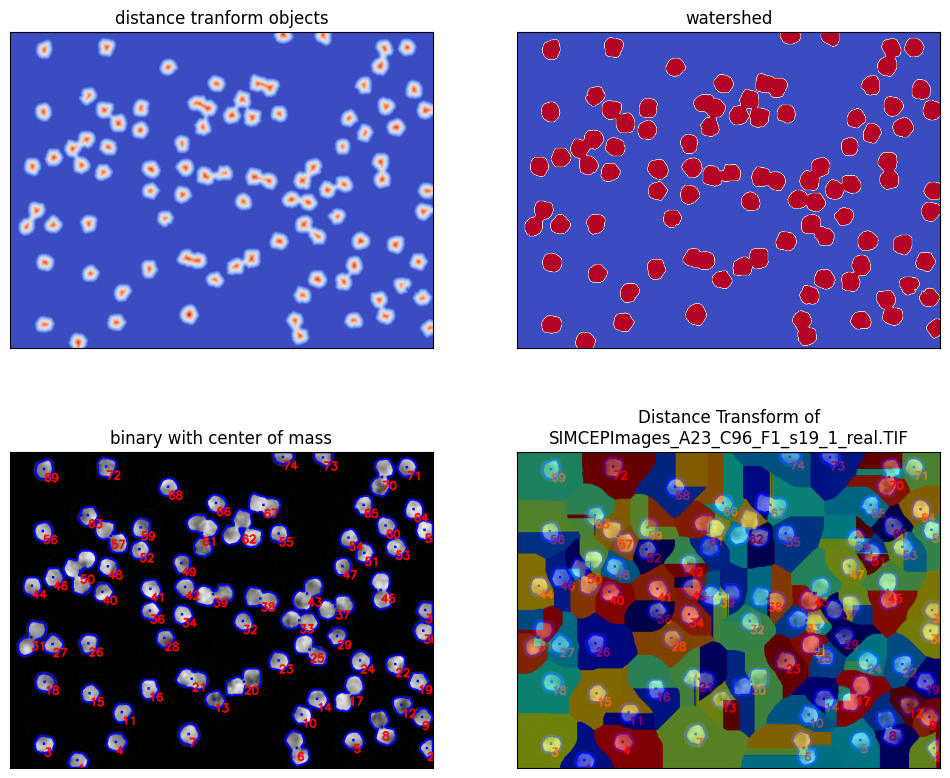

In [5]:
# sources
# https://www.geeksforgeeks.org/distance-transformation-in-image-python-opencv/
# https://gist.github.com/jgomezdans/402500
# https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html
# https://stackoverflow.com/questions/31054352/applying-matplotlib-color-map-to-opencv-image
# https://stackoverflow.com/questions/40895785/using-opencv-to-overlay-transparent-image-onto-another-image
# https://stackoverflow.com/questions/60765915/python-opencv-floodfill-function-strange-type-errors
# https://stackoverflow.com/questions/70251361/imextendedmin-and-imimposemin-functions-in-python-for-watershed-seeds-from-dista


# import modules
import codecs, json
import cv2
from matplotlib import cm
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image 
from scipy import ndimage
from skimage.segmentation import watershed


distTransform_t = ndimage.distance_transform_edt(myImageThresholded.astype(np.uint8))
# plt.imshow(distTransform_t)
waterShedValues = watershed(- distTransform_t)

cv2.imwrite('./Figures/cellscontourized.png', myImageContours)
cv2.imwrite('./Figures/distTransform.png', distTransform * 255)
cv2.imwrite('./Figures/watershedvalues.png', waterShedValues)

image_array  = plt.imread("./Figures/watershedvalues.png")
randomValues = np.linspace(0,1,256)
np.random.shuffle(randomValues)
cmap = plt.cm.colors.ListedColormap(plt.cm.jet(randomValues))
dictRandomValues = {}
dictRandomValues["randomValues"] = randomValues.tolist()
with open('./ModulesOwn/cmap.json', 'w') as myFile:
    json.dump(dictRandomValues, myFile)
myFile.close()
imageTmp = Image.fromarray(np.uint8(cmap(image_array)*255))
imageTmp.save('./Figures/watershedvaluesRGB.png')
myBackgroundImage = cv2.imread('./Figures/cellscontourized.png')
myOverlayImage    = cv2.imread('./Figures/watershedvaluesRGB.png')
myBackgroundImage = cv2.addWeighted(myBackgroundImage, 0.5, myOverlayImage, 0.5, 0)

# plot figures
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (12, 10), sharex = True, sharey = True)
ax = axes.ravel()
ax[0].imshow(distTransform, cmap   = cm.coolwarm)
ax[0].set_title('distance tranform objects')
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].imshow(myImageThresholded, cmap = cm.coolwarm)
ax[1].set_title('watershed')
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[2].imshow(myImageContours, cmap = cm.coolwarm)
ax[2].set_title('binary with center of mass')
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[3].imshow(myBackgroundImage, cmap = cm.coolwarm)
ax[3].set_title("Distance Transform of\n" + fileName)
ax[3].set_xticks([])
ax[3].set_yticks([])

plt.show()

## 1.2 <a name="StatisticalAnalysisOfAutomatedNucleiCellCount">Statistical Analysis of Automated Nuclei Cell Count</a>

Goal: Count nuclei of a set of fluorescence micrographs in an automated way and identify the offset on each image by comparison to the ground truth number

------------------------------------------------------------------------------------------------------------------------------------------
                    print scheme: <filename>  <TrueNumberNuclei>  <ComputedNumberNuclei>
------------------------------------------------------------------------------------------------------------------------------------------
SIMCEPImages_A01_C1_F1_s01_w1.TIF: 1  1		SIMCEPImages_A01_C1_F1_s02_w1.TIF: 1  1		SIMCEPImages_A01_C1_F1_s03_w1.TIF: 1  1		
SIMCEPImages_A02_C5_F1_s01_w1.TIF: 5  5		SIMCEPImages_A02_C5_F1_s02_w1.TIF: 5  5		SIMCEPImages_A02_C5_F1_s03_w1.TIF: 5  5		
SIMCEPImages_A03_C10_F1_s01_w1.TIF: 10  10	SIMCEPImages_A03_C10_F1_s02_w1.TIF: 10  10	SIMCEPImages_A03_C10_F1_s03_w1.TIF: 10  9	
SIMCEPImages_A04_C14_F1_s01_w1.TIF: 14  14	SIMCEPImages_A04_C14_F1_s02_w1.TIF: 14  14	SIMCEPImages_A04_C14_F1_s03_w1.TIF: 14  14	
SIMCEPImages_A05_C18_F1_s01_w1.TIF: 18  18	SIMCEPImages_A05_C18_F1_s02_w1.TIF: 18  18	SIMCEPImages_A05_C18_F1_s03_w1.TIF: 18  

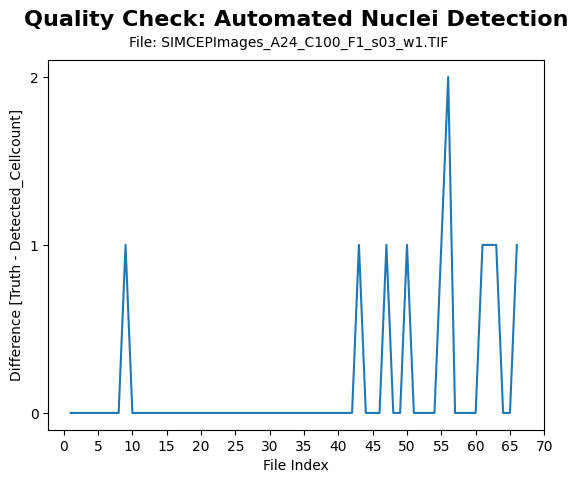

In [6]:
# sources
# https://www.kaggle.com/code/voglinio/separating-nuclei-masks-using-convexity-defects
# https://stackoverflow.com/questions/32401806/get-mask-from-contour-with-opencv
# https://stackoverflow.com/questions/50591442/convert-3-dim-image-array-to-2-dim
# https://www.tutorialspoint.com/how-to-compute-the-area-and-perimeter-of-an-image-contour-using-opencv-python
# https://pynative.com/python-list-files-in-a-directory/

# data source
# Synthetic cells, Accession number BBBC005 · Version 1
# A. Lehmussola, P. Ruusuvuori, J. Selinummi, H. Huttunen and O. Yli-Harja,
# "Computational Framework for Simulating Fluorescence Microscope Images With Cell Populations,"
# in IEEE Transactions on Medical Imaging, vol. 26, no. 7, pp. 1010-1016, July 2007, doi: 10.1109/TMI.2007.896925.
# 
# A. Lehmussola, P. Ruusuvuori, J. Selinummi, T. Rajala and O. Yli-Harja,
# "Synthetic Images of High-Throughput Microscopy for Validation of Image Analysis Methods,"
# in Proceedings of the IEEE, vol. 96, no. 8, pp. 1348-1360, Aug. 2008, doi: 10.1109/JPROC.2008.925490.

# import modules
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.measure import regionprops
import ModulesOwn.A_Groundwork as Groundwork
import matplotlib.pyplot as plt
import numpy as np

xpoints = []
ypoints = []


# tresholds for
# 1Cell:             single cell
# 2CellCluster:      two cells
# gt2CellCluster:    greater than two cells
dictThresholdValues                 = {}
dictThresholdValues["1Cell"]        = 0
dictThresholdValues["2CellCluster"] = 1.05
dictThresholdValues["gt2CellCluster"] = 1.2


myThresholdValue                    = 70
meanFilledAreaAll                   = []

res = []
dir_path = './DataExternalSyntheticCells'

for path in os.listdir(dir_path):
    if os.path.isfile(os.path.join(dir_path, path)):
        res.append(path)

# compute mean area for a single nucleus with all file info
for ii, fileNameTmp in enumerate(res):
    fileName          = fileNameTmp
    cellCountTruth    = int(fileName[fileName.find('_C') + 2 : fileName.find('_F')])
    myImage                                            = cv2.imread('./DataExternalSyntheticCells/' + fileName)
    myImageGray                                        = cv2.cvtColor(myImage, cv2.COLOR_BGR2GRAY)
    myImageThresholded                                 = np.zeros(myImageGray.shape)
    myImageThresholded[myImageGray > myThresholdValue] = 1
    myImageThresholded                                 = ndimage.binary_fill_holes(myImageThresholded).astype(int)
    meanFilledArea = Groundwork.meanFilledArea(myImage, myImageThresholded, dictThresholdValues)
    meanFilledAreaAll.append(meanFilledArea)
meanFilledArea = mean(meanFilledAreaAll) 

# execute main algorith on all files to identify cells and cell cluster
print("-" * 138)
print(" " * 20 + "print scheme: " + "<filename>  <TrueNumberNuclei>  <ComputedNumberNuclei>")
print("-" * 138)
for ii, fileNameTmp in enumerate(res):
    fileName          = fileNameTmp
    cellCountTruth    = int(fileName[fileName.find('_C') + 2 : fileName.find('_F')])
    myImage                                            = cv2.imread('./DataExternalSyntheticCells/' + fileName)
    myImageGray                                        = cv2.cvtColor(myImage, cv2.COLOR_BGR2GRAY)
    myImageThresholded                                 = np.zeros(myImageGray.shape)
    myImageThresholded[myImageGray > myThresholdValue] = 1
    myImageThresholded                                 = ndimage.binary_fill_holes(myImageThresholded).astype(int)

    
    cellCount, contours, myImageContours, myMaskContoursAll = Groundwork.identifyCellContoursAndAreaOverlays(myImage,
                                                                                                             myImageThresholded,
                                                                                                             dictThresholdValues,
                                                                                                             meanFilledArea)
    if ii < 6:
        print(fileName + ": " + str(cellCountTruth) + "  " + str(cellCount) + "\t\t", end = '')
    else:
        print(fileName + ": " + str(cellCountTruth) + "  " + str(cellCount) + "\t", end = '')
    
    if (ii + 1) % 3 == 0:
        print("\n", end = '')
    
    xpoints.append(ii + 1)
    ypoints.append(cellCountTruth - cellCount)

# plot figure
TitleString = "Quality Check: Automated Nuclei Detection"
x = np.linspace(0, 1, 2)
plt.plot(xpoints, ypoints)
plt.title(TitleString, fontweight="bold", fontsize = 16, y = 1.07)
plt.suptitle("File: " + fileName, fontsize = 10, y = 0.93)
plt.xlabel("File Index")
plt.ylabel("Difference [Truth - Detected_Cellcount]")
plt.xticks(np.arange(0, 72, 5))
plt.yticks(np.arange(0, 3, 1))
plt.show()

## 1.3 <a name="EllipseFitOnNuclei">Ellipse Fit on Nuclei</a>

Goal: Ellipse fit of each nuclei region

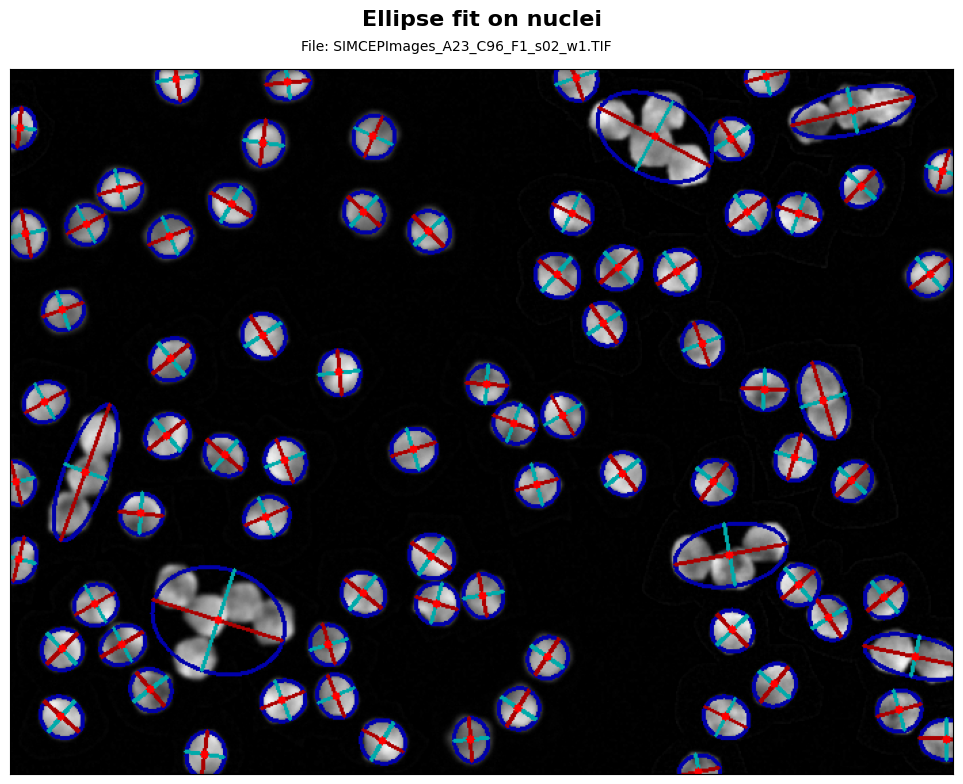

In [7]:
# sources
# https://www.kaggle.com/code/voglinio/separating-nuclei-masks-using-convexity-defects
# https://de.mathworks.com/matlabcentral/answers/43435-i-couldn-t-understand-convex-area
# https://stackoverflow.com/questions/32401806/get-mask-from-contour-with-opencv
# https://stackoverflow.com/questions/50591442/convert-3-dim-image-array-to-2-dim
# https://stackoverflow.com/questions/62698756/opencv-calculating-orientation-angle-of-major-and-minor-axis-of-ellipse
# https://www.tutorialspoint.com/how-to-compute-the-area-and-perimeter-of-an-image-contour-using-opencv-python
# https://www.tutorialspoint.com/how-to-fit-the-ellipse-to-an-object-in-an-image-using-opencv-python

# sources of main algorithms
# https://www.kaggle.com/code/voglinio/separating-nuclei-masks-using-convexity-defects
# User: Costas Voglis
# and
# https://stackoverflow.com/questions/62698756/opencv-calculating-orientation-angle-of-major-and-minor-axis-of-ellipse
# User: fmw42, Fred Weinhaus

# import modules
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import regionprops
import math


fileName           = "SIMCEPImages_A23_C96_F1_s02_w1.TIF"
cellCountTruth     = int(fileName[fileName.find('_C')+2:fileName.find('_F')])
myThresholdValue   = 70

myImage            = cv2.imread('./DataExternalSyntheticCells/' + fileName)
myImageGray        = cv2.cvtColor(myImage, cv2.COLOR_BGR2GRAY)

myImageThresholded                                 = np.zeros(myImageGray.shape)
myImageThresholded[myImageGray > myThresholdValue] = 1
myImageThresholded                                 = ndimage.binary_fill_holes(myImageThresholded).astype(int)

cellCount           = 0
contours, hierarchy = cv2.findContours(myImageThresholded.astype(np.uint8), 1, 2)
myMaskContoursAll   = np.zeros(myImage.shape)
numberOfObjects     = len(contours)
list_multicore      = []

for ii, cnt in enumerate(contours):
	M               = cv2.moments(cnt)
	area            = cv2.contourArea(cnt)
	perimeter       = cv2.arcLength(cnt, True)
	perimeter       = round(perimeter, 1)
	
	# compute center of mass
	# see sources of main algorithms
	if M['m00'] != 0.0:
		x1 = int(M['m10'] / M['m00'])
		y1 = int(M['m01'] / M['m00'])
		x1_rounded = round(x1)
		y1_rounded = round(y1)
	myMaskZeros       = np.zeros(myImage.shape, np.uint8)
	myMaskContoursTmp = cv2.drawContours(image = myMaskZeros, contours=[cnt], contourIdx = -1, color = (255, 255, 255), thickness = cv2.FILLED)
	myMaskContours                           = np.zeros(myImage.shape)
	myMaskContours[myMaskContoursTmp == 255] = 1
	props = regionprops(myMaskContoursTmp, cache = False)
	prop = props[0]


	# compute ellipse fit incl. major and minor axis
	# see sources of main algorithms
	ellipse = cv2.fitEllipse(cnt)
	(xc, yc), (d1, d2), angle = ellipse
	cv2.ellipse(myImage, ellipse, (0, 0, 170), 2)
	rmajor = max(d1, d2) / 2
	if angle > 90:
		angle = angle - 90
	else:
		angle = angle + 90
	x1 = xc + math.cos(math.radians(angle)) * rmajor
	y1 = yc + math.sin(math.radians(angle)) * rmajor
	x2 = xc + math.cos(math.radians(angle + 180)) * rmajor
	y2 = yc + math.sin(math.radians(angle + 180)) * rmajor
	cv2.line(myImage, (int(x1), int(y1)), (int(x2), int(y2)), (170, 0, 0), 2)

	rminor = min(d1, d2) / 2
	if angle > 90:
		angle = angle - 90
	else:
		angle = angle + 90

	x1 = xc + math.cos(math.radians(angle)) * rminor
	y1 = yc + math.sin(math.radians(angle)) * rminor
	x2 = xc + math.cos(math.radians(angle + 180)) * rminor
	y2 = yc + math.sin(math.radians(angle + 180)) * rminor
	cv2.line(myImage, (int(x1),int(y1)), (int(x2),int(y2)), (0, 170, 170), 2)

	# mark center
	xc, yc = ellipse[0]
	cv2.circle(myImage, (int(xc), int(yc)), 3, (255, 0, 0), -1)


# plot figure
fig, ax = plt.subplots(figsize = (20, 10))
im      = ax.imshow(myImage)
divider = make_axes_locatable(ax)
cax     = divider.new_vertical(size = "5%",
                           pad = 0.3,
                           pack_start = True)
plt.title("Ellipse fit on nuclei", fontweight="bold", fontsize = 16, y = 1.05)
plt.suptitle("File: " + fileName, fontsize = 10, y = 0.91)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# 100. <a name="Appendix">Appendix</a>

## 100.1 <a name="htmlExportOfCode">.html-Export of Code</a>

In [8]:
# export code to html
import os
os.system("jupyter nbconvert AnalysisOfBioImages.ipynb --to html")

0